In [608]:
from collections import namedtuple
from functools import partial
import random
from typing import List, NamedTuple

import gym

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import plotly.express as ple

from IPython.display import clear_output

In [609]:
Transition = namedtuple('Transition', 'state action reward next_state done')

In [610]:
class VectorizeWrapper(gym.Wrapper):
    def __init__(self, make_env, num_envs: int=1):
        super().__init__(make_env())
        self.num_envs = num_envs
        self.envs = [make_env() for env_index in range(self.num_envs)]
    
    def reset(self):
        return np.asarray([env.reset() for env in self.envs])
    
    def reset_at(self, idx: int):
        return self.envs[idx].reset()
    
    def step(self, actions):
        assert len(actions) == len(self.envs)
        next_states, rewards, dones, infos = [], [], [], []
        for env, action in zip(self.envs, actions):
            next_state, reward, done, info = env.step(action)
            next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)
            infos.append(info)
        return np.asarray(next_states), rewards, dones, infos

In [611]:
class ReplayBuffer:
    def __init__(self, capacity: int = 100000):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        
    def push(self, transition):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = transition
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size: int) -> List[NamedTuple]:
        if len(self.buffer) < batch_size:
            raise ValueError(f"Can't sample {batch_size} num elements from buffer of size {self.buffer}")
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

In [729]:
def create_model(state_dim: int, action_dim: int, hidden_sizes: List[int], use_bias: bool = True):
    model = tf.keras.models.Sequential()
    model.add(layers.InputLayer(input_shape=state_dim))
    for hidden_size in hidden_sizes:
        model.add(layers.Dense(hidden_size, use_bias=use_bias, kernel_initializer='he_normal', dtype=tf.float64))
        model.add(layers.ReLU(dtype=tf.float64))
    model.add(layers.Dense(action_dim, use_bias=use_bias, dtype=tf.float64))
    
    return model

def sync_models(model1, model2):
    model2.set_weights(model1.get_weights())

In [730]:
class EpsScheduler:
    def __init__(self, init_eps: float = 1.0, final_eps: float = 0.01, steps: int = 10_000):
        self.init_eps = init_eps
        self.steps = steps
        self.final_eps = final_eps
        self.step = (self.init_eps - self.final_eps) / self.steps
        self.cur_step = -1
        self_eps = init_eps
        
    def __call__(self, current_step = None):
        if current_step is None:
            current_step = self.cur_step
            self.cur_step += 1
        eps = max(self.final_eps, self.init_eps - self.step * current_step)
        self._eps = eps
        return eps
    
    @property
    def eps(self):
        return self._eps
    
    def reset(self):
        self.cur_step = -1

In [731]:
class Agent:
    def __init__(self, state_dim: int, action_dim: int):
        self.state_dim = state_dim
        self.action_dim = action_dim
        
    def act(self, state):
        raise NotImplementedError()
        
    def update(self, transitions):
        raise NotImplementedError()

In [732]:
class DQN(Agent):
    def __init__(self, state_dim: int, action_dim: int, hidden_sizes: List[int], gamma: float=0.95):
        super(DQN, self).__init__(state_dim, action_dim)
        self.q_net = create_model(state_dim, action_dim, hidden_sizes)
        self.optimizer = tf.keras.optimizers.Adam(0.0005)
        self.eps = EpsScheduler(steps=15_000)
        self.gamma = gamma
        
    def act(self, state):
        batch_size = state.shape[0]
        eps = self.eps()
        random_steps = np.random.randint(self.action_dim, size=batch_size)
        best_q_steps = np.argmax(self.q_net(state), axis=1)
        if np.random.rand() < eps:
            action = random_steps
        else:
            action = best_q_steps
        return action
    
    def _prepare_batches(self, transitions):
        state, action, reward, next_state, done = [], [], [], [], []
        for transition in transitions:
            state.append(transition.state)
            action.append(transition.action)
            reward.append(transition.reward)
            next_state.append(transition.next_state)
            done.append(transition.done)
        state = np.array(state)
        action = np.array(action)
        reward = np.array(reward)
        next_state = np.array(next_state)
        done = np.array(done)
        return state, action, reward, next_state, done
    
    def update(self, transitions):
        state, action, reward, next_state, done = self._prepare_batches(transitions)
        with tf.GradientTape() as tape:
            Q_pred = tf.reduce_sum(self.q_net(state)*tf.one_hot(action, self.action_dim, dtype=tf.float32), axis=1)
            Q_next = tf.stop_gradient(tf.reduce_max(self.q_net(next_state), axis=1))
            
            loss = tf.reduce_mean((reward + (1 - done) * self.gamma * Q_next - Q_pred)**2)
        gradients = tape.gradient(loss, self.q_net.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.q_net.trainable_variables))

In [733]:
class DDQN(DQN):
    def __init__(self, state_dim: int, action_dim: int, hidden_sizes: List[int], gamma: float=0.95, tau: float = 0.08):
        super(DDQN, self).__init__(state_dim, action_dim, hidden_sizes, gamma)
        self.target_net = create_model(state_dim, action_dim, hidden_sizes)
        self.tau = tau
        sync_models(self.q_net, self.target_net)
    
    def synchronize(self):
        sync_models(self.q_net, self.target_net)
        
    def exp_average_weights(self):
        for target_w, original_w in zip(self.target_net.trainable_variables, 
                                        self.q_net.trainable_variables):
            target_w.assign(target_w * (1 - self.tau) + original_w * self.tau)
    
    def update(self, transitions):
        state, action, reward, next_state, done = self._prepare_batches(transitions)
        with tf.GradientTape() as tape:
            Q_pred = tf.reduce_sum(self.q_net(state) * tf.one_hot(action, self.action_dim, dtype=tf.float64), axis=1)
            best_actions = tf.one_hot(tf.argmax(self.q_net(next_state), axis=1), self.action_dim, dtype=tf.float64)
            Q_next = tf.stop_gradient(tf.reduce_sum(self.target_net(next_state) * best_actions, axis=1))
            loss = tf.reduce_mean((reward + (1 - done) * self.gamma * Q_next - Q_pred )**2)
        gradients = tape.gradient(loss, self.q_net.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.q_net.trainable_variables))

In [734]:
def train(agent_cls, env_name, num_steps: int = 20000, num_envs: int = 32, plot_every: int=300, 
          sync_every=None, exp_average: bool = False):
    if exp_average and sync_every is not None:
        raise ValueError("Choose one type of target network update.")
    
    env = VectorizeWrapper(partial(gym.make, env_name), num_envs)
    state_dim = env.observation_space.shape
    action_dim = env.action_space.n
    agent = agent_cls(state_dim, action_dim, hidden_sizes=[30, 30], gamma=0.95)
    
    rewards = []
    episode_rewards = [0 for _ in range(num_envs)]
    
    state = env.reset()
    for t in range(num_steps):
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        transitions = [Transition(state=s, action=a, reward=r, next_state=n, done=d)
                       for s, a, r, n, d in zip(state, action, reward, next_state, done)]

        agent.update(transitions)
        
        for i in range(num_envs):
            episode_rewards[i] += reward[i]
        
        for i in range(num_envs):
            if done[i]:
                rewards.append(episode_rewards[i])
                episode_rewards[i] = 0
                env.reset_at(i)
        if t % plot_every == 99:
            clear_output()
            print("Eps: ", agent.eps.eps)
            plt.plot(rewards)
            plt.show()
            
        if sync_every is not None and t % sync_every == 0:
            agent.synchronize()
            
        if exp_average:
            agent.exp_average_weights()
        
        state = next_state
    return rewards

In [735]:
def train_exp_rep(agent_cls, env_name, num_steps: int = 20000, num_envs: int = 32, plot_every: int=300, batch_size=32,
                  sync_every=None, exp_average: bool = False):
    if exp_average and sync_every is not None:
        raise ValueError("Choose one type of target network update.")
    
    env = VectorizeWrapper(partial(gym.make, env_name), num_envs)
    state_dim = env.observation_space.shape
    action_dim = env.action_space.n
    agent = agent_cls(state_dim, action_dim, hidden_sizes=[24, 24], gamma=0.95)
    replay_buffer = ReplayBuffer()
    
    rewards = []
    episode_rewards = [0 for _ in range(num_envs)]
    
    state = env.reset()
    for t in range(num_steps):
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        transitions = [Transition(state=s, action=a, reward=r, next_state=n, done=d)
                       for s, a, r, n, d in zip(state, action, reward, next_state, done)]
        
        for transition in transitions:
            replay_buffer.push(transition)

        if len(replay_buffer) >= batch_size:
            transitions = replay_buffer.sample(batch_size)
            agent.update(transitions)
        
        for i in range(num_envs):
            episode_rewards[i] += reward[i]
        
        for i in range(num_envs):
            if done[i]:
                rewards.append(episode_rewards[i])
                episode_rewards[i] = 0
                env.reset_at(i)
        if t % plot_every == 99:
            clear_output()
            print("Eps: ", agent.eps.eps)
            plt.plot(rewards)
            plt.show()
            
        if sync_every is not None and t % sync_every == 0:
            agent.synchronize()
            
        if exp_average:
            agent.exp_average_weights()
        
        state = next_state
    return rewards

Eps:  0.01


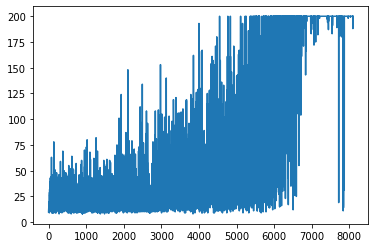

In [736]:
rewards = train(DDQN, 'CartPole-v0', num_steps=20000, num_envs=32, exp_average=True)#sync_every=100)

Eps:  0.01


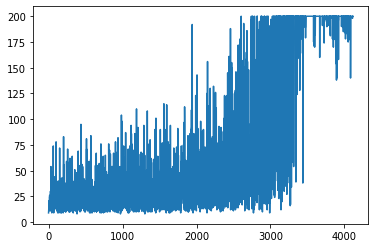

In [721]:
rewards_exp = train_exp_rep(DDQN, 'CartPole-v0', num_steps=20000, num_envs=16, batch_size=32, 
                            exp_average=True)#sync_every=100)

In [540]:
ple.line(x=range(len(rewards)), y=rewards, title="Q-learning")

In [543]:
ple.line(x=range(len(rewards_exp)), y=rewards_exp, title="Q-learning + experience replay")

In [737]:
ple.line(x=range(len(rewards)), y=rewards, title="Double Q-learning")

In [723]:
ple.line(x=range(len(rewards_exp)), y=rewards_exp, title="Double Q-learning + experience replay")